# Rock and roll deaths

![Leading causes of death](DEATH/cause-cloud.png)

## Dataset

Here we examine data from [wikipedia - Lists of deaths in rock and roll](https://en.wikipedia.org/wiki/List_of_deaths_in_rock_and_roll) dumped to csv using [wikitables](wikitables.geeksta.net). The following cleaning was applied: Age ranges set to lower value, multi deaths split to line each, formatted and corrected date column, location column edited to give consistent country data. The resulting data frame has these columns:

| Column         | Type | Original | Description           |
|----------------|------|----------|-----------------------|
| Name           | str  | y        | Name, and affiliation |
| Age            | int? | y        | Age at death          |
| Date           | str  | y        | Date string           |
| Location       | str  | ~        | Place of death        |
| Cause of death | str  | y        | Death cause           |
| Clean Age      | int  | n        | int                   |
| Clean Date     | str  | n        | YYYY-MM-DD            |

The word cloud above was generated using the Cause of death column in the dataset. 

## Setup environment and load data

In [7]:
%matplotlib inline

In [8]:
# from functools import reduce
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tabulate
from IPython.core.display import display, HTML

In [6]:
# Helpers
def disp_df(df):
    """Show html table with dataframe"""
    display(HTML(tabulate.tabulate(df, headers=df.columns, tablefmt='html')))

In [9]:
# Read data
death = pd.read_csv("DEATH/list_of_deaths_in_rock_and_roll_cleaned.csv")
# Overwrite with clean values
death["Age"] = death["CleanAge"]
death["Date"] = pd.to_datetime(death["CleanDate"])
# Drop unused columns
death = death[["Name", "Age", "Date", "Location", "Cause of death"]]
# Add column with year of birth
death["Born"] = death["Date"].dt.year - death["Age"]
# Set index to date of death
death.index = death['Date']
# Add year, month
death["Year"] = death["Date"].dt.year
death["Month"] = death["Date"].dt.month.fillna(-1).astype(int)
death["WeekDay"] = death["Date"].dt.weekday.fillna(-1).astype(int)
# Add age and born counted in decades
def decadize(col):
    return ((col // 10)*10).fillna(-1).astype(int)
death["Decade"] = decadize(death["Date"].dt.year)
death["AgeDecade"] = decadize(death["Age"])
death["BornDecade"] = decadize(death["Born"])
# Drop data with invalid date
death = death[death["Decade"] > 0]

## Date of death

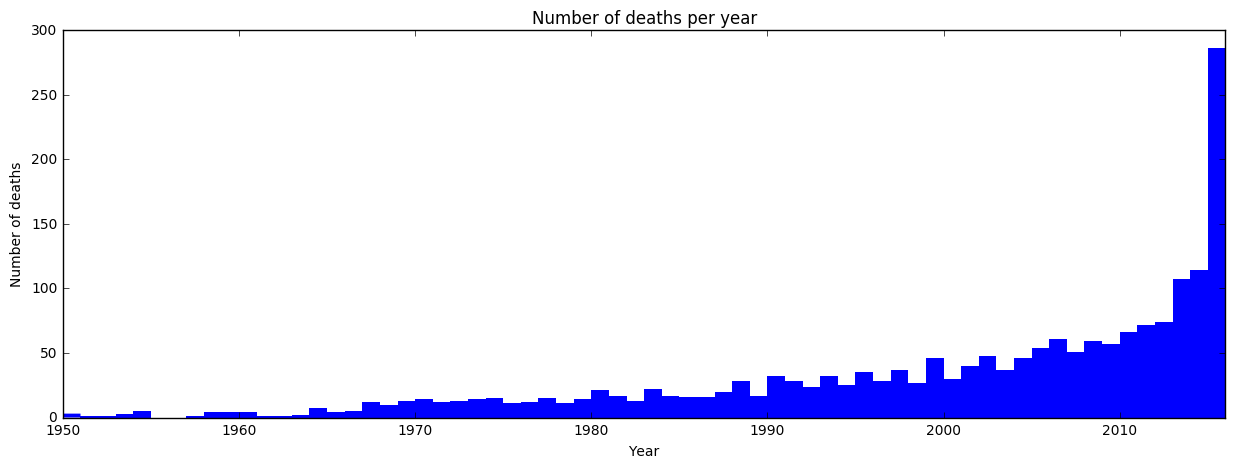

In [8]:
ax = death["Year"].plot.hist(
    figsize=(15, 5),
    bins=int(death["Year"].max() - death["Year"].min()),
    edgecolor="none",
    title="Number of deaths per year")
_ = ax.set_xlim(1950, 2016)
_ = ax.set_xlabel("Year")
_ = ax.set_ylabel("Number of deaths")

The data very clearly increases fast with time. Still, even an exponential trend would not have predicted the amount seen in 2016. Let's take a look at how when in the year deaths occur has changed with time. If there is no effect we expect each month to have 1/12 (8.3%) of deaths.

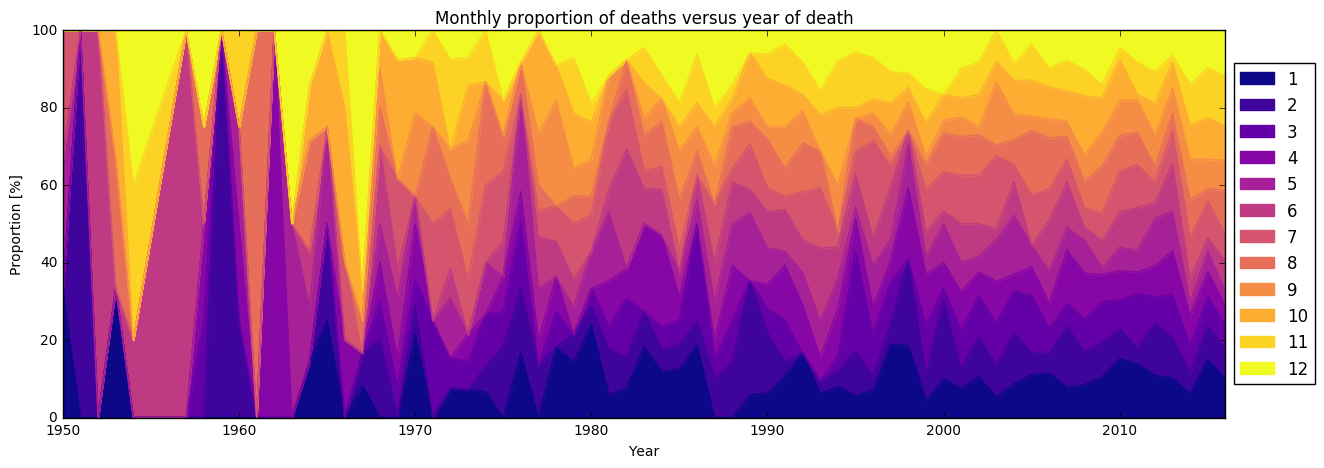

In [9]:
ax = death.groupby(["Year", "Month"]).size().unstack(level=-1).apply(
    lambda x: x * 100. / x.sum(), axis=1).plot.area(
        stacked=True,
        cmap="plasma",
        figsize=(15, 5),
        title="Monthly proportion of deaths versus year of death")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylim(0, 100)
_ = ax.set_ylabel("Proportion [%]")
_ = ax.set_xlabel("Year")

In the plot it is clear that early data has low statistics and thus is very noisy. Still in later there are on occasion strong peaks and valleys. The largest jumps seems to occur around the shift of the year. Now, we examine deaths by month and weekday, broken down by decade instead.

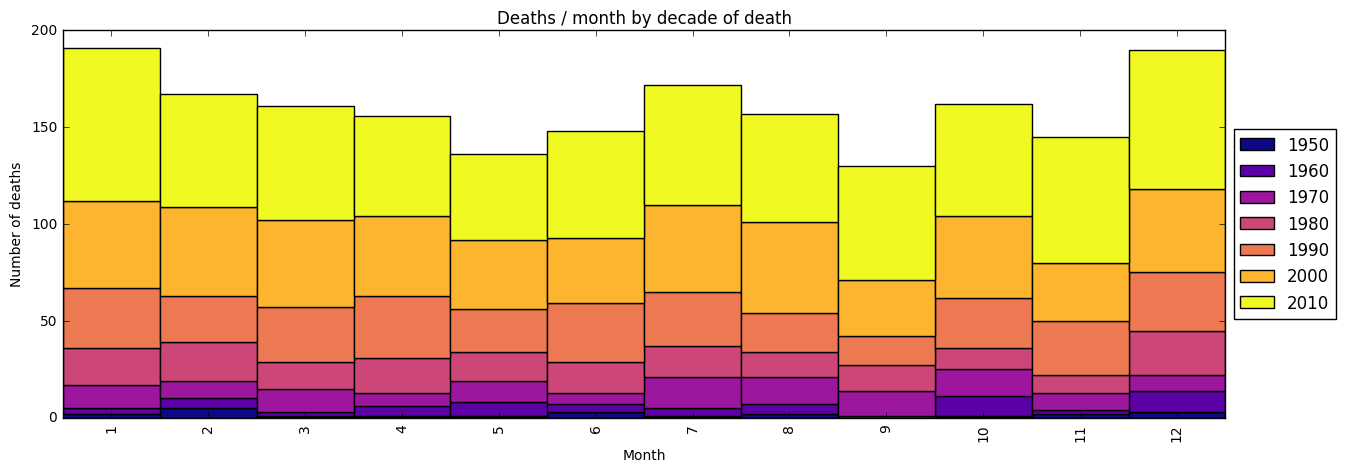

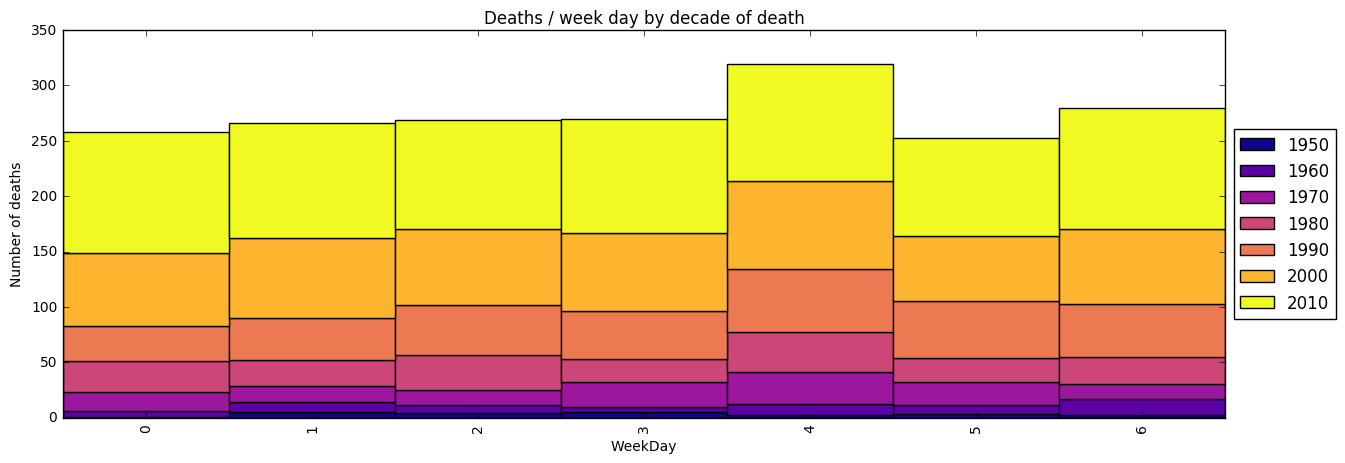

In [10]:
ax = death.groupby(["Month", "Decade"]).size().unstack(level=-1).plot.bar(
    stacked=True,
    width=1.0,
    figsize=(15, 5),
    cmap="plasma",
    title="Deaths / month by decade of death")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
_ = ax.set_ylabel("Number of deaths")
_ = ax.set_xlim(-0.5, 11.5)

ax = death.groupby(["WeekDay", "Decade"]).size().unstack(level=-1).plot.bar(
    stacked=True,
    width=1.0,
    figsize=(15, 5),
    cmap="plasma",
    title="Deaths / week day by decade of death")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
_ = ax.set_ylabel("Number of deaths")
_ = ax.set_xlim(-0.5, 6.5)

Clearly deaths occured most in Jan/Dec and July, with very few in May and Sept. For Jan the increase seems extra strong during the 2010s. Most days occur on Fridays, and the least deaths on Saturdays.

## Age at death

To get an overview, we break the data down by age in decades at time of death, and then break each of those by birth decade. This gives a simultaneous, indicates most common birth decades as well as most common age.

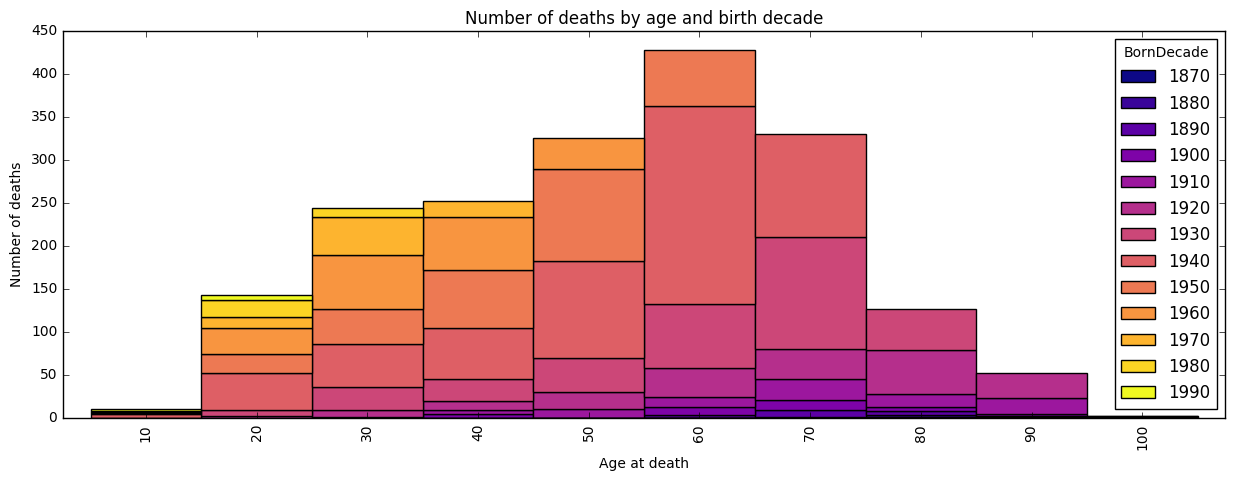

In [11]:
ax = death[death["Decade"]>0].groupby(["AgeDecade", "BornDecade"]).size().unstack(
    level=-1).plot.bar(stacked=True,
                       cmap="plasma",
                       figsize=(15, 5),
                       width=1.0,
                       title="Number of deaths by age and birth decade")
_ = ax.set_ylabel("Number of deaths")
_ = ax.set_xlabel("Age at death")


From the colors we see most people were born in the 1940's and 50's, and from the bars that most people died around 60 years of age. We also see quite few teenage and very few centennial deaths. Lets zoom in to death by age under 50.

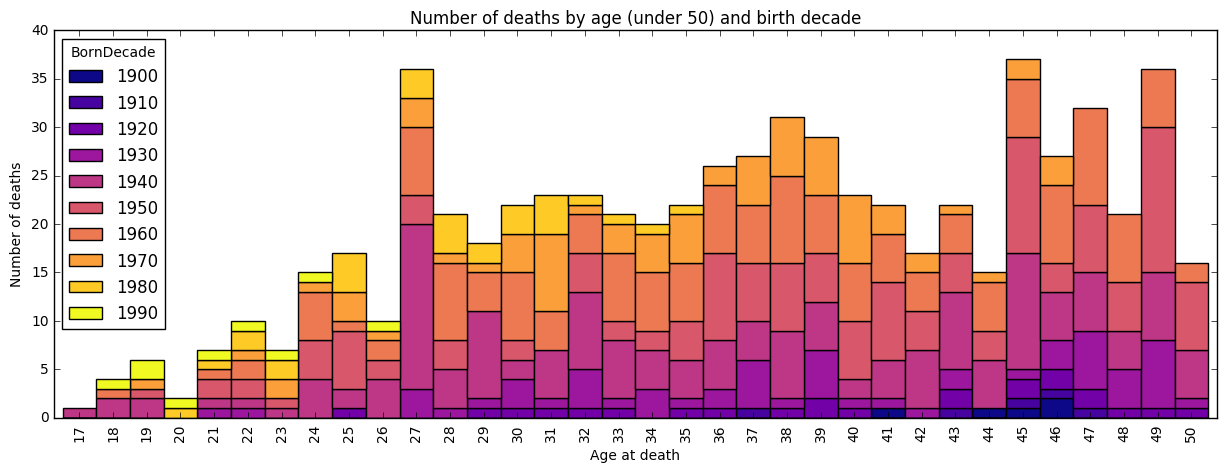

In [12]:
ax = death[death["Age"] < 51].groupby(["Age", "BornDecade"]).size().unstack(
    level=-1).plot.bar(
        stacked=True,
        cmap="plasma",
        figsize=(15, 5),
        width=1.0,
        title="Number of deaths by age (under 50) and birth decade")
_ = ax.set_ylabel("Number of deaths")
_ = ax.set_xlabel("Age at death")

Here we see the famous [club 27](https://en.wikipedia.org/wiki/27_Club) peak, with disproportionately many deaths at 27 years of age. By comparing decade of birth to  neighboring bars, it is clear that the biggest contribution is from people born in the 1940s.  Not until 45 years of age is death this high again.

## Location

The last comma separated entry in Location field should be country, it is invalid for many entries. We clean the data and extract the top ten most common countries.

In [13]:
death['Country'] = death["Location"].str.strip().str.lower().str.split(",").str[
    -1].str.strip().replace('', np.nan)
d10 = death['Country'].dropna().value_counts().head(10)
disp_df(pd.DataFrame(d10))

,Country
usa,1309
england,146
canada,30
australia,22
france,17
germany,17
sweden,14
spain,12
japan,8
mexico,7


The data set is highly skewed towards the USA.

## Cause of death

In [14]:
death["Cause"] = death["Cause of death"].str.strip().str.lower()
c10 = death["Cause"].dropna().value_counts().head(10)
disp_df(pd.DataFrame(c10))
cancer = death[death["Cause"].str.contains("cancer").fillna(False)]["Cause"].value_counts().head(10)
disp_df(pd.DataFrame(cancer))

,Cause
heart attack,176
cancer,125
lung cancer,79
heart failure,53
car accident,50
natural causes,38
stroke,32
pneumonia,31
suicide,30
heroin overdose,26


,Cause
cancer,125
lung cancer,79
prostate cancer,23
liver cancer,22
pancreatic cancer,14
breast cancer,8
throat cancer,7
stomach cancer,7
esophageal cancer,7
colon cancer,6


The most common causes of deaths are cancers (341) and heart attacks. Most cancers are unspecified, of the specified lung cancer is the dominating cause.